In [13]:
# I had a problem with using multiprocessing pool.map, to solve the problem I must have saved all the functions (like 
# chunk_mapper) to separate file and then import it with command from ipynb.fs.full.'file' import 'function'. I also 
# had to add 
#if __name__ == '__main__':
#   with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
# before each p.map
# I think that because of that programs for small data with parallel solution are slower, in the bigger data they 
# seems to be faster though

In [65]:
## Task 1 ##

import numpy as np
a=1
b=10
nrange =2
mx = np.random.uniform(a,b,(10**5,10**2)) #matrix of rand i will be using

In [2]:
mx.shape

(100000, 100)

In [4]:
# method without mapreduce
def in_range(mx,a,b,nrange):   
    bounds = np.linspace(a, b, num=nrange+1)
    data_chunks = chunkify(mx,10)
    reduced_all = np.zeros(nrange)
    for chunk in data_chunks:
        W=[]
        for i in range(nrange):
            W.append(sum(sum((mx>=bounds[i]) * (mx<bounds[i+1]))))
        reduced_all=reduced_all+W
    return reduced_all
            

In [5]:
%%time
def chunkify(mx,n):
     return [mx[i::n] for i in range(n)]
in_range(mx,1,10,4) #we are counting numbers inside 4 ranges -  array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ])
#array([R1 : 25002700., R2 : 24995060., R3 : 24994340., R4 : 25007900.])

Wall time: 27.1 s


array([25002700., 24995060., 24994340., 25007900.])

In [56]:
# optimal form
def in_range_mapreduced(mx,nchunks,bounds): 
    from functools import reduce
    import collections
    reduced=[]
    data_chunks = chunkify(mx,nchunks)
    mapped = map(chunk_mapper,data_chunks,itertools.repeat(bounds,len(data_chunks)))  
    reduced_all=reduce(reducer,mapped)
    sort =  sorted(reduced_all.items())
    final = []
    for i,j in sort:
        final.extend([[[bounds[i-1],bounds[i]],j]])

    return final

In [66]:
%%time
import multiprocessing
import collections
import itertools
def chunk_mapper(chunk,bounds):
    c = collections.Counter()
     # ranges
    for x in chunk:
        mapped =[np.where(bounds == max(bounds[bounds<xx]))[0][0]+1 for xx in x]
        mapped = zip(itertools.repeat(1,len(x)), mapped)
        for a,i in mapped:
            c[i] += a
    return c
def reducer(a,b):
    return a+b
def chunkify(mx,n):
     return [mx[i::n] for i in range(n)]   
  
in_range_mapreduced(mx,100,np.array([0,3,6,10]))  # program is counting values in [0,3], [3,6], [6,10] ranges

Wall time: 2min 1s


[[[0, 3], 2223981], [[3, 6], 3335596], [[6, 10], 4440423]]

In [63]:
# parallel
def in_range_mapreduced(mx,nchunks,bounds): 
    from functools import reduce
    import collections    
    from ipynb.fs.full.chunk_mapper_task_1 import chunk_mapper
    reduced=[]
    data_chunks = chunkify(mx,nchunks)
    if __name__ == '__main__':
        with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
            mapped = p.starmap(chunk_mapper,zip(data_chunks,itertools.repeat(bounds,len(data_chunks))))  
    reduced_all=reduce(reducer,mapped)
    sort =  sorted(reduced_all.items())
    final = []
    for i,j in sort:
        final.extend([[[bounds[i-1],bounds[i]],j]])
    return final

In [67]:
%%time
import multiprocessing
import collections
import itertools
def reducer(a,b):
    return a+b
def chunkify(mx,n):
     return [mx[i::n] for i in range(n)]     
in_range_mapreduced(mx,100,np.array([0,3,6,10]))

Wall time: 1min 40s


[[[0, 3], 2223981], [[3, 6], 3335596], [[6, 10], 4440423]]

In [ ]:
## Task 2 ##
#scraping and preprocessing books#
import requests
from bs4 import BeautifulSoup
def go_gutenberg(file_format,book_no):
    url = "https://www.gutenberg.org/ebooks/"
    r =requests.get('https://www.gutenberg.org/ebooks/' + str(book_no))
    r_html  = r.text
    soup = BeautifulSoup(r_html,"html.parser")
    for file in soup.find_all('a',class_="link"):
        if file_format in file.text:
            get_book=file.get('href')
            g = requests.get('https://www.gutenberg.org/' + get_book)
            with open("C:\\Users\\Adam\\Desktop\\data\\gutenberg\\"+str(book_no)+".txt",'wb') as open_file:
                for chunk in g.iter_content(10000):
                    open_file.write(chunk)





def main():
    for i in range(500):
        go_gutenberg("Text",500+i)

if __name__=="__main__":main()

In [63]:
f = open("C:\\Users\\Adam\\Desktop\\data\\gutenberg\\500.txt", encoding="utf8")
print(f.read())

produced charles keller tina david widger dashes small checks quick pass gutchecked twice jeebies spellcheck adventures pinocchio c collodi pseudonym carlo lorenzini translated italian carol della chiesa chapter 1 happened mastro cherry carpenter found piece wood wept laughed like child centuries ago lived “a king!” little readers say immediately children mistaken upon time piece wood expensive piece wood far common block firewood one thick solid logs put fire winter make cold rooms cozy warm know really happened yet fact remains one fine day piece wood found shop old carpenter real name mastro antonio everyone called mastro cherry tip nose round red shiny looked like ripe cherry soon saw piece wood mastro cherry filled joy rubbing hands together happily mumbled half “this come nick time shall use make leg table.” grasped hatchet quickly peel bark shape wood give first blow stood still arm uplifted heard wee little voice say beseeching tone “please careful hit hard!” look surprise shon

In [47]:
import string

def process_file(filename):
    """ opens a file and passes back a list of its words"""
    h = dict()
    string = []
    with open(filename, encoding="utf8") as fin:
        for line in fin:
            if "START OF THIS PROJECT GUTENBERG" in line:
                break
        for line in fin:
            if "END OF THIS PROJECT GUTENBERG" in line:
                break
            string.extend(line)
            process_line(line, h)      
        return h, sum(h.values()), ''.join(string)

def process_line(line, h):
    line = line.replace('-', ' ')

    for word in line.split():
        word = word.strip(string.punctuation + string.whitespace)
        word = word.lower()
        h[word] = h.get(word,0)+1

In [48]:
process_file("C:\\Users\\Adam\\Desktop\\data\\gutenberg\\500.txt")

({'produced': 1,
  'charles': 1,
  'keller': 1,
  'tina': 1,
  'david': 1,
  'widger': 1,
  'dashes': 1,
  'small': 19,
  'checks': 1,
  'quick': 11,
  'pass': 1,
  'gutchecked': 1,
  'twice': 6,
  'jeebies': 1,
  'spellcheck': 1,
  'adventures': 2,
  'pinocchio': 399,
  'c': 12,
  'collodi': 2,
  'pseudonym': 2,
  'carlo': 2,
  'lorenzini': 2,
  'translated': 1,
  'italian': 1,
  'carol': 1,
  'della': 1,
  'chiesa': 1,
  'chapter': 37,
  '1': 1,
  'happened': 13,
  'mastro': 21,
  'cherry': 7,
  'carpenter': 8,
  'found': 46,
  'piece': 21,
  'wood': 34,
  'wept': 7,
  'laughed': 11,
  'like': 106,
  'child': 4,
  'centuries': 2,
  'ago': 6,
  'lived': 8,
  '“a': 13,
  'king!”': 1,
  'little': 171,
  'readers': 3,
  'say': 30,
  'immediately': 10,
  'children': 17,
  'mistaken': 1,
  'upon': 12,
  'time': 66,
  'expensive': 1,
  'far': 38,
  'common': 3,
  'block': 1,
  'firewood': 4,
  'one': 159,
  'thick': 2,
  'solid': 1,
  'logs': 2,
  'put': 33,
  'fire': 28,
  'winter': 1,
  '

In [41]:
import string
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def process_files(filename):
    """ opens a file and passes back a list of its words"""
    h = dict()
    string_txt = []
    with open(filename, encoding="utf8") as fin:
        for line in fin:
            line = line.replace('-', ' ')
            for word in line.split():
                if word in  stop_words:
                    continue
                word = word.strip(string.punctuation + string.whitespace)
                word = word.lower()
                string_txt.append(word) 
        replace = ' '.join(string_txt)
        return replace


In [42]:
for i in range(500):
    try:
        directory = "C:\\Users\\Adam\\Desktop\\data\\gutenberg\\"+str(500+i)+".txt"
        text = process_files(directory)
        outfile = open(directory, "w", encoding="utf8")
        outfile.writelines(text)
        outfile.close()
    except:
        pass

In [2]:
## mapreduce 

import string

def processed_file_p(filename):
    """ opens a file and passes back a list of its words"""
    import collections
    
    with open(filename, encoding="utf8") as fin:
        mapped = map(chunk_mapper,fin) 
        try:
            reduced = reduce(sum, mapped)
        except:
            reduced = collections.Counter()

        return reduced

def processed_line_p(line, c):
    line = line.replace('-', ' ')
    mapped =[word for word in line.split()]
    mapped = zip(itertools.repeat(1,len(line.split())), mapped)
    for a,i in mapped:
        c[i] += a

def chunk_mapper(line):
    c = collections.Counter()
    processed_line_p(line, c) 
    return c



In [3]:
%%time
import itertools
from functools import reduce
import collections
d = collections.Counter()
for i in range(500):
    try:
        d = d+processed_file_p("C:\\Users\\Adam\\Desktop\\data\\gutenberg\\"+str(500+i)+".txt")
    except:
        pass
d.most_common(50)

Wall time: 2min 7s


[('one', 40585),
 ('said', 37272),
 ('de', 32624),
 ('would', 30579),
 ('could', 21608),
 ('upon', 21136),
 ('time', 20617),
 ('man', 19501),
 ('see', 18960),
 ('two', 18378),
 ('like', 17656),
 ('may', 17195),
 ('little', 17167),
 ('great', 16781),
 ('la', 16370),
 ('first', 16269),
 ('made', 15810),
 ('et', 15668),
 ('mr', 15633),
 ('might', 14302),
 ('p', 14196),
 ('well', 14174),
 ('le', 13834),
 ('day', 13220),
 ('much', 13165),
 ('never', 12933),
 ('long', 12808),
 ('without', 12798),
 ('good', 12695),
 ('old', 12649),
 ('à', 12608),
 ('us', 12518),
 ('must', 12497),
 ('men', 12482),
 ('life', 12191),
 ('shall', 11907),
 ('know', 11891),
 ('came', 11534),
 ('many', 11484),
 ('come', 11178),
 ('even', 11175),
 ('every', 11136),
 ('people', 11000),
 ('way', 10596),
 ('still', 10575),
 ('back', 9967),
 ('go', 9953),
 ('three', 9928),
 ('yet', 9803),
 ('hand', 9635)]

In [10]:
## parallel
import string
def processed_file_p(filename):
    """ opens a file and passes back a list of its words"""
    import collections
    from ipynb.fs.full.Task_2 import chunk_mapper
    with open(filename, encoding="utf8") as fin:    
        mapped = p.map(chunk_mapper,fin) 
        try:
            reduced = reduce(sum, mapped)
        except:
            reduced = collections.Counter()

        return reduced


        




In [11]:
%%time
import multiprocessing
p = multiprocessing.Pool(multiprocessing.cpu_count())
import itertools
from functools import reduce
import collections
import multiprocessing
d = collections.Counter()
for i in range(500):
    try:
        d = d+processed_file_p("C:\\Users\\Adam\\Desktop\\data\\gutenberg\\"+str(500+i)+".txt")
    except:
        pass
d.most_common(50)

Wall time: 3min 34s


[('one', 40585),
 ('said', 37272),
 ('de', 32624),
 ('would', 30579),
 ('could', 21608),
 ('upon', 21136),
 ('time', 20617),
 ('man', 19501),
 ('see', 18960),
 ('two', 18378),
 ('like', 17656),
 ('may', 17195),
 ('little', 17167),
 ('great', 16781),
 ('la', 16370),
 ('first', 16269),
 ('made', 15810),
 ('et', 15668),
 ('mr', 15633),
 ('might', 14302),
 ('p', 14196),
 ('well', 14174),
 ('le', 13834),
 ('day', 13220),
 ('much', 13165),
 ('never', 12933),
 ('long', 12808),
 ('without', 12798),
 ('good', 12695),
 ('old', 12649),
 ('à', 12608),
 ('us', 12518),
 ('must', 12497),
 ('men', 12482),
 ('life', 12191),
 ('shall', 11907),
 ('know', 11891),
 ('came', 11534),
 ('many', 11484),
 ('come', 11178),
 ('even', 11175),
 ('every', 11136),
 ('people', 11000),
 ('way', 10596),
 ('still', 10575),
 ('back', 9967),
 ('go', 9953),
 ('three', 9928),
 ('yet', 9803),
 ('hand', 9635)]

<BarContainer object of 15 artists>

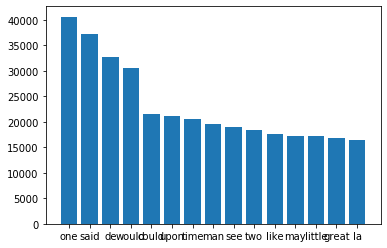

In [4]:
from matplotlib import pyplot as plt
most_common = d.most_common(15)
val, weight = zip(*[(k, v) for k,v in most_common])
plt.bar(val,weight)

In [10]:
## Task 3 ##
def S(j, d):
    s = 0.0
    k = 0
    while k <= d:
        r = 8*k+j
        s = (s + pow(16, d-k, r) / r) % 1.0
        k += 1
    oldt = s
    newt = 0
    while (oldt != newt):
        oldt = newt
        newt = s + pow(16, d-k) / (8*k+j)
        s = newt
        k += 1
    return s

def pi(d):
    d = int(d)
    d -= 1
    x = (4*S(1, d) - 2*S(4, d) - S(5, d) - S(6, d)) % 1.0
    return "%014x" % int(x * 16**14)




In [79]:
pi(10**6)
#26C65E52CB4593 - result from article

'26c65e52cb3188'

In [80]:
pi(10**7)
#17AF5863EFED8D - result from article

'17af5863f0f5b0'

In [82]:
pi(2)

'43f6a8885a3090'

In [12]:
#reduce - not optimal form
def mapreduce_pi(n,chunks): 
    mx = np.linspace(1,n,n)
    data_chunks = chunkify(mx,chunks)
    reduce=[]
    for chunk in data_chunks:
        mapped =(pi(int(x)) for x in chunk)
        mapped = zip(chunk, mapped)
        reduce.extend(mapped)
    reduce_all = sorted(reduce, key=lambda tup: tup[0])   
    return reduce_all

In [15]:
%%time
def chunkify(mx,n):
     return [mx[n*i:n*(i+1)] for i in range((len(mx) // n)+1)]
import numpy as np    
mapreduce_pi(1000,100)

Wall time: 6.41 s


[(1.0, '243f6a8885a300'),
 (2.0, '43f6a8885a3090'),
 (3.0, '3f6a8885a308d0'),
 (4.0, 'f6a8885a308d30'),
 (5.0, '6a8885a308d320'),
 (6.0, 'a8885a308d3170'),
 (7.0, '8885a308d31318'),
 (8.0, '885a308d313190'),
 (9.0, '85a308d31319e0'),
 (10.0, '5a308d313198c0'),
 (11.0, 'a308d313198a50'),
 (12.0, '308d313198a320'),
 (13.0, '08d313198a2de6'),
 (14.0, '8d313198a2e050'),
 (15.0, 'd313198a2e0350'),
 (16.0, '313198a2e036e0'),
 (17.0, '13198a2e037090'),
 (18.0, '3198a2e0370790'),
 (19.0, '198a2e03707360'),
 (20.0, '98a2e0370733d0'),
 (21.0, '8a2e0370734518'),
 (22.0, 'a2e037073449b0'),
 (23.0, '2e03707344a3a4'),
 (24.0, 'e03707344a4090'),
 (25.0, '03707344a40940'),
 (26.0, '3707344a409330'),
 (27.0, '707344a4093810'),
 (28.0, '07344a409381e3'),
 (29.0, '7344a4093822a0'),
 (30.0, '344a40938222e0'),
 (31.0, '44a40938222970'),
 (32.0, '4a409382229980'),
 (33.0, 'a4093822299ee8'),
 (34.0, '4093822299f2c0'),
 (35.0, '093822299f31b0'),
 (36.0, '93822299f31d20'),
 (37.0, '3822299f31cffc'),
 (38.0, '8

In [6]:
#mapreduce optimal form
def mapper_chunk(chunk):
    mapped =map(pi,chunk)
    mapped = zip(chunk, mapped)
    return list(mapped)
def mapreduce_pi(n,chunks): 
    mx = np.linspace(1,n,n)
    data_chunks = chunkify(mx,chunks)
    mapper  = map(mapper_chunk,data_chunks)
    return (list(mapper))

In [9]:
%%time
def chunkify(mx,n):
     return [mx[n*i:n*(i+1)] for i in range((len(mx) // n)+1)]
import numpy as np    
mapreduce_pi(10**3,10*2)

[[(1.0, '243f6a8885a300'), (2.0, '43f6a8885a3090'), (3.0, '3f6a8885a308d0'), (4.0, 'f6a8885a308d30'), (5.0, '6a8885a308d320'), (6.0, 'a8885a308d3170'), (7.0, '8885a308d31318'), (8.0, '885a308d313190'), (9.0, '85a308d31319e0'), (10.0, '5a308d313198c0'), (11.0, 'a308d313198a50'), (12.0, '308d313198a320'), (13.0, '08d313198a2de6'), (14.0, '8d313198a2e050'), (15.0, 'd313198a2e0350'), (16.0, '313198a2e036e0'), (17.0, '13198a2e037090'), (18.0, '3198a2e0370790'), (19.0, '198a2e03707360'), (20.0, '98a2e0370733d0')], [(21.0, '8a2e0370734518'), (22.0, 'a2e037073449b0'), (23.0, '2e03707344a3a4'), (24.0, 'e03707344a4090'), (25.0, '03707344a40940'), (26.0, '3707344a409330'), (27.0, '707344a4093810'), (28.0, '07344a409381e3'), (29.0, '7344a4093822a0'), (30.0, '344a40938222e0'), (31.0, '44a40938222970'), (32.0, '4a409382229980'), (33.0, 'a4093822299ee8'), (34.0, '4093822299f2c0'), (35.0, '093822299f31b0'), (36.0, '93822299f31d20'), (37.0, '3822299f31cffc'), (38.0, '822299f31cffe0'), (39.0, '22299f31d

[]

In [14]:
#mapreduce optimal form paralel
def mapreduce_pi(n,chunks): 
    from ipynb.fs.full.Task_3 import mapper_chunk
    from ipynb.fs.full.Task_3 import S
    from ipynb.fs.full.Task_3 import pi
    mx = np.linspace(1,n,n)
    data_chunks = chunkify(mx,chunks)
    if __name__ == '__main__':
        with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
            mapper  = p.map(mapper_chunk,data_chunks)
    return (list(mapper))


In [15]:
%%time
import multiprocessing
def chunkify(mx,n):
     return [mx[n*i:n*(i+1)] for i in range((len(mx) // n)+1)]
import numpy as np    
mapreduce_pi(10**3,10*2)

Wall time: 7.14 s


[[(1.0, '243f6a8885a300'),
  (2.0, '43f6a8885a3090'),
  (3.0, '3f6a8885a308d0'),
  (4.0, 'f6a8885a308d30'),
  (5.0, '6a8885a308d320'),
  (6.0, 'a8885a308d3170'),
  (7.0, '8885a308d31318'),
  (8.0, '885a308d313190'),
  (9.0, '85a308d31319e0'),
  (10.0, '5a308d313198c0'),
  (11.0, 'a308d313198a50'),
  (12.0, '308d313198a320'),
  (13.0, '08d313198a2de6'),
  (14.0, '8d313198a2e050'),
  (15.0, 'd313198a2e0350'),
  (16.0, '313198a2e036e0'),
  (17.0, '13198a2e037090'),
  (18.0, '3198a2e0370790'),
  (19.0, '198a2e03707360'),
  (20.0, '98a2e0370733d0')],
 [(21.0, '8a2e0370734518'),
  (22.0, 'a2e037073449b0'),
  (23.0, '2e03707344a3a4'),
  (24.0, 'e03707344a4090'),
  (25.0, '03707344a40940'),
  (26.0, '3707344a409330'),
  (27.0, '707344a4093810'),
  (28.0, '07344a409381e3'),
  (29.0, '7344a4093822a0'),
  (30.0, '344a40938222e0'),
  (31.0, '44a40938222970'),
  (32.0, '4a409382229980'),
  (33.0, 'a4093822299ee8'),
  (34.0, '4093822299f2c0'),
  (35.0, '093822299f31b0'),
  (36.0, '93822299f31d20'),


In [31]:
## Task 4 ##
import numpy as np

A = np.array([[2, 4], [5, -6]])
B = np.array([[9, -3], [3, 6]])

In [32]:
i = 0

preprocessed =[]
for row in A:
    i += 1
    j = 0
    for value in row:
        j += 1
        preprocessed.extend([['M', i,j, value]])
i = 0

for row in B:
    i += 1
    j = 0
    for value in row:
        j += 1
        preprocessed.extend([['N', i,j, value]])
        

In [33]:
preprocessed

[['M', 1, 1, 2],
 ['M', 1, 2, 4],
 ['M', 2, 1, 5],
 ['M', 2, 2, -6],
 ['N', 1, 1, 9],
 ['N', 1, 2, -3],
 ['N', 2, 1, 3],
 ['N', 2, 2, 6]]

In [34]:
mapper=[]

for touple in preprocessed:   
    if touple[0] == 'M':
        mapper.extend([[touple[2],[touple[0],touple[1],touple[3]]]]) 
    
    if touple[0] == 'N':
        mapper.extend([[touple[1],[touple[0],touple[2],touple[3]]]])


    
    

In [35]:
mapper

[[1, ['M', 1, 2]],
 [2, ['M', 1, 4]],
 [1, ['M', 2, 5]],
 [2, ['M', 2, -6]],
 [1, ['N', 1, 9]],
 [1, ['N', 2, -3]],
 [2, ['N', 1, 3]],
 [2, ['N', 2, 6]]]

In [36]:
s = sorted(mapper, key = lambda x: (x[0]))
import itertools
chunks=[]
key_f = lambda x: x[0]
for key, group in itertools.groupby(s, key_f):
    chunks.extend([list(group)])
chunks

[[[1, ['M', 1, 2]], [1, ['M', 2, 5]], [1, ['N', 1, 9]], [1, ['N', 2, -3]]],
 [[2, ['M', 1, 4]], [2, ['M', 2, -6]], [2, ['N', 1, 3]], [2, ['N', 2, 6]]]]

In [37]:

reduced=[]
import collections
c = collections.Counter()
from itertools import groupby
for chunk in chunks:
    M_list=[]
    N_list=[]
    
    for part in chunk:
        if part[1][0]=='M':
            M_list.extend([[part[1][1],part[1][2]]]) 
        else:
            N_list.extend([[part[1][1],part[1][2]]]) 
    for m in M_list:
        for n in N_list:
            reduced.extend([[[m[0],n[0]],m[1]*n[1]]])   
my_list2 = []
for i, g in groupby(sorted(reduced), key=lambda x: x[0]):
    my_list2.append([i, sum(v[1] for v in g)])

print(my_list2)
 

        

[[[1, 1], 30], [[1, 2], 18], [[2, 1], 27], [[2, 2], -51]]


In [38]:
# mapreduce optimal
def mapper_func(touple):
    if touple[0] == 'M':
        return [touple[2],[touple[0],touple[1],touple[3]]]
    if touple[0] == 'N':
        return [touple[1],[touple[0],touple[2],touple[3]]]
mapper = map(mapper_func,preprocessed)


In [39]:
s = sorted(mapper, key = lambda x: (x[0]))
import itertools
chunks=[]
key_f = lambda x: x[0]
for key, group in itertools.groupby(s, key_f):
    chunks.extend([list(group)])
chunks

[[[1, ['M', 1, 2]], [1, ['M', 2, 5]], [1, ['N', 1, 9]], [1, ['N', 2, -3]]],
 [[2, ['M', 1, 4]], [2, ['M', 2, -6]], [2, ['N', 1, 3]], [2, ['N', 2, 6]]]]

In [46]:
%%time
# mapreduce
import multiprocessing
import collections
c = collections.Counter()
from itertools import groupby
def mapper_chunks(chunk):
    reduced=[]
    M_list=[]
    N_list=[]   
    for part in chunk:
        if part[1][0]=='M':
            M_list.extend([[part[1][1],part[1][2]]]) 
        else:
            N_list.extend([[part[1][1],part[1][2]]]) 
    for m in M_list:
        for n in N_list:
            reduced.extend([[[m[0],n[0]],m[1]*n[1]]])
    return reduced      
mapped = map(mapper_chunks,chunks)
list_map = list(mapped)
vector=[]
for i in list_map:
    vector.extend(i)

    
my_list2 = []
for i, g in groupby(sorted(vector), key=lambda x: x[0]):
    my_list2.append([i, sum(v[1] for v in g)])

print(my_list2)
 

[[[1, 1], 30], [[1, 2], 18], [[2, 1], 27], [[2, 2], -51]]
Wall time: 1.99 ms


In [43]:
%%time
#mapreduce parallel
import multiprocessing
import collections
from ipynb.fs.full.Task_4 import mapper_chunks
c = collections.Counter()
from itertools import groupby

if __name__ == '__main__':
        with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
            mapped = p.map(mapper_chunks,chunks)
list_map = list(mapped)
vector=[]
for i in list_map:
    vector.extend(i)

    
my_list2 = []
for i, g in groupby(sorted(vector), key=lambda x: x[0]):
    my_list2.append([i, sum(v[1] for v in g)])

print(my_list2)

[[[1, 1], 30], [[1, 2], 18], [[2, 1], 27], [[2, 2], -51]]
Wall time: 3.83 s
